# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook is an implementation of Traffic Sign Classifier using LeNet neural network for the Udacity Self Drivig Car Nanodegree program. 

You can find this project on [this github repo](https://github.com/Vladimir-Lazic/CarND-Traffic-Sign-Classifier-Project)

Below I will adress each point in the [project rubric](https://review.udacity.com/#!/rubrics/481/view).

The project files are: 

- `'traffic_sign_classifier_project.ipynb'` is a jupyter notebook containing the code 

- `'traffic_sign_classifier_project.html'` is the HTML export of the code 

- `'traffic_sign_classifier_project.pdf'` is the project writeup in pdf


In [1]:
import pickle
import matplotlib.pyplot as plt
import random
import numpy as np
import csv
import warnings
from sklearn.utils import shuffle
import cv2

# Suppressing TensorFlow FutureWarings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
image_label_file = 'signnames.csv'

def parse_image_labels(input_csc_file):
    reader = csv.reader(open(input_csc_file, 'r'))
    retVal = {}
    for row in reader:
        key, value = row
        if key == 'ClassId':
            continue
        retVal.update({int(key): value})
    return retVal

# Parsing image label csv file
image_labels = parse_image_labels(image_label_file)


## Data set

In the two cells bellow several rubric points are addressed:

- `'Dataset Summary'` in which I display the basic propertives of the dataset like the number of images, number of classes and image shape

- `'Exploratory Visualization'` in which I display selected images of the dataset

- `'Preprocessing'` where I apply preprocessing techniques to the dataset. The techniques I have implemented are dataset normalization and grayscale. My initial idea was to train the network using RGB images, so it was required that I normalize the values of image pixels in order to improve the the perscision of the network. However, after initial few tries I have opted againts this approach and went with the training the network on a grayscale input data set. This approach proved to be more effective in terms of achieving desired network percision. 

In the cell below I load the train, validation and tests set and apply the grayscaleing on each image for each set.

In [3]:
"""
    Functions for dataset exploration
"""

figsize_default = plt.rcParams['figure.figsize']

def samples_stat(features, labels):
    h = [0 for i in range(len(labels))]
    samples = {}
    for idx, l in enumerate(labels):
        h[l] += 1
        if l not in samples:
            samples[l] = features[idx]
    return h, samples

def dataset_exploration(features, labels):
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    histo, samples = samples_stat(features, labels)
    total_class = len(set(labels))
    ncols = 4
    nrows = 11

    _, axes = plt.subplots(nrows=nrows, ncols=ncols)

    class_idx = 0
    for r in range(nrows):
        for c in range(ncols):
            a = axes[r][c]
            a.axis('off')
            if class_idx in samples:
                a.imshow(samples[class_idx])
            if class_idx in image_labels:
                a.set_title("No.{} {}(#{})".format(class_idx, image_labels[class_idx], histo[class_idx]), fontsize=12)
            class_idx += 1
    plt.rcParams['figure.figsize'] = figsize_default


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples
Grayscaling training set
Grayscaled Training Set:   34799 samples
Grayscale Image Shape: (32, 32, 1)


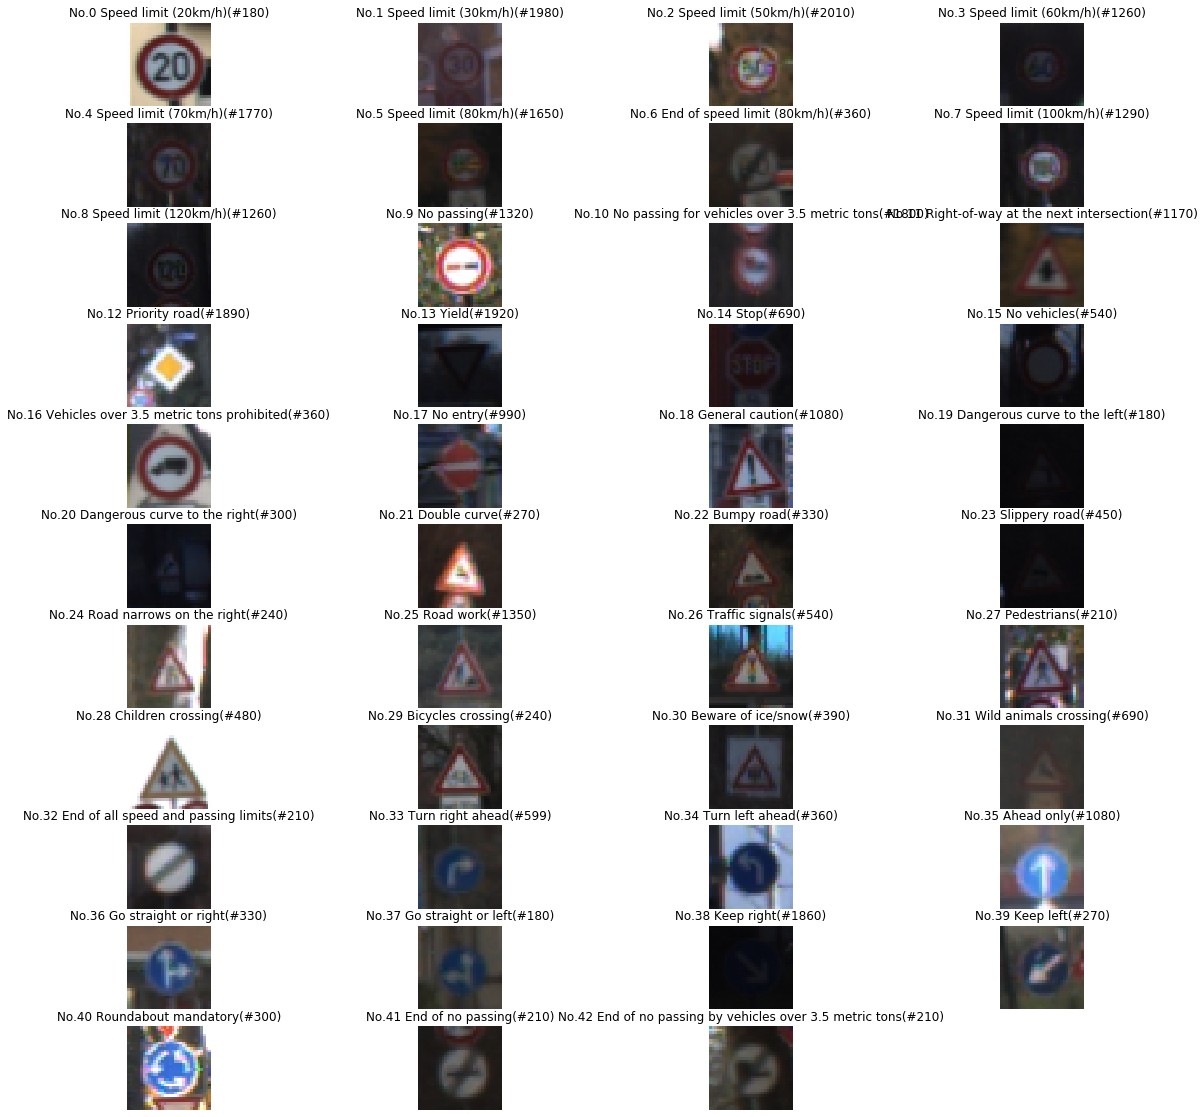

In [4]:
training_file = './data_set/train.p'
validation_file = './data_set/valid.p'
testing_file = './data_set/test.p'

# Loading the data set
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert (len(X_train) == len(y_train))
assert (len(X_valid) == len(y_valid))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))

def image_normalize(image):
    image = np.divide(image, 255)
    return image

def dataset_normalization(X_data):
    X_normalized = X_data.copy()
    num_examples = len(X_data)
    for i in range(num_examples):
        image = X_normalized[i]
        normalized_image = image_normalize(image)
        X_normalized[i] = normalized_image
    return X_normalized

def dataset_grayscale(X_data):
    X_grayscale = []
    num_examples = len(X_data)
    for i in range(num_examples):
        image = X_data[i]
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        X_grayscale.append(gray.reshape(32, 32, 1))
    return np.array(X_grayscale)

dataset_exploration(X_train, y_train)

print('Grayscaling training set')
X_train = dataset_grayscale(X_train)
X_valid = dataset_grayscale(X_valid)
X_test = dataset_grayscale(X_test)

assert (len(X_train) == len(y_train))
print("Grayscaled Training Set:   {} samples".format(len(X_train)))
print("Grayscale Image Shape: {}".format(X_train[0].shape))

X_train, y_train = shuffle(X_train, y_train)

## Neural Network

In the two cells bellow several rubric points are addressed:

- `'Model Architecture'` : For model architecture I have opted for standard LeNet neural network. The neural network takes an input shape of 32x32x1, which is a grayscaled image. The network contains two convolutional layers. The convolutional layers are a combination of convolution, relu activation function, max pool layer. After that we have three fully connected layers. After each respective layers I have implemented a dropout layer, for reducing network overfitting. The dropout layers have 2 different keep probabilities. One probability is used for the output of convolutional layer, and the other is used for the output of fully connected layers. The output of the network is an array of logits size 43. The network is implemented in lenet.py file.

- `'Model Training'` : The training of the network was done on the input sample of the grayscaled images. The images have been preprocessed in the cells above. The network has been trained with a learing rate of 0.001 over 30 epoch with a bach size of 64. For optimizer I used Adam optimizer.

- `'Solution Approach'` : After a serveral tried tunning the hyperparameters I found the best was to use a learning rate of 0.001 and the batch size of 64. For the number of epoch I found that 30 number of epoch gave the network enough tries to achieve desired validation accuracy without having to take too much time or run the risk of the network overfitting. After 30 epoch the validation accuracy that was achieved was 94.6%. After getting the desired validation accuracy the network was then introduced to the test set. On the first try running the network on the tests set the accuracy achieved was 93.2% which is a good inicator that the network was trained correctly and that it didn't overfit.  

In [5]:
from lenet import *

EPOCHS = 30
BATCH_SIZE = 64

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, None)
one_hot_y = tf.one_hot(y, 43)

logits = LeNet(x)

# Training pipeline
rate = 0.001

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

# Model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [6]:
def evaluate(X_data, y_data, model='lenet'):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x,
                                                           y: batch_y,
                                                           keep_prob_conv: 1.0,
                                                           keep_prob: 1.0})

        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


def predict_single_label(x_image):
    sess = tf.get_default_session()
    logits_output = sess.run(tf.argmax(logits, 1),
                             feed_dict={
                                 x: np.expand_dims(x_image, axis=0),
                                 keep_prob_conv: 1.0,
                                 keep_prob: 1.0})
    classification_index = logits_output[0]
    logits_return = logits_output.copy()
    return image_labels[classification_index], classification_index, logits_return


def batch_predict(X_data, BATCH_SIZE=64):
    num_examples = len(X_data)
    batch_predict = np.zeros(num_examples, dtype=np.int32)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset + BATCH_SIZE]
        batch_predict[offset:offset + BATCH_SIZE] = sess.run(tf.argmax(logits, 1),                                                                                              feed_dict={x: batch_x,                                                                                                        keep_prob_conv: 1.0,
                                                                        keep_prob: 1.0})
    return batch_predict

In [7]:
saver = tf.train.Saver()

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x,
                                                    y: batch_y,
                                                    keep_prob_conv: 1.0,
                                                    keep_prob: 0.7})

        print("EPOCH {} ...".format(i + 1))
        validation_accuracy = evaluate(X_valid, y_valid)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './model/lenet')
    print("Model saved")

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

Training...

EPOCH 1 ...
Validation Accuracy = 0.680

EPOCH 2 ...
Validation Accuracy = 0.824

EPOCH 3 ...
Validation Accuracy = 0.855

EPOCH 4 ...
Validation Accuracy = 0.901

EPOCH 5 ...
Validation Accuracy = 0.913

EPOCH 6 ...
Validation Accuracy = 0.899

EPOCH 7 ...
Validation Accuracy = 0.928

EPOCH 8 ...
Validation Accuracy = 0.922

EPOCH 9 ...
Validation Accuracy = 0.927

EPOCH 10 ...
Validation Accuracy = 0.917

EPOCH 11 ...
Validation Accuracy = 0.922

EPOCH 12 ...
Validation Accuracy = 0.927

EPOCH 13 ...
Validation Accuracy = 0.930

EPOCH 14 ...
Validation Accuracy = 0.932

EPOCH 15 ...
Validation Accuracy = 0.941

EPOCH 16 ...
Validation Accuracy = 0.934

EPOCH 17 ...
Validation Accuracy = 0.943

EPOCH 18 ...
Validation Accuracy = 0.941

EPOCH 19 ...
Validation Accuracy = 0.944

EPOCH 20 ...
Validation Accurac

In [8]:
# Check Test Accuracy
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model/.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./model/./lenet
Test Accuracy = 0.934


## Model testing

In the cells below I have addressed the rubric points regarding testing the model on new images.

- `'Acquiring New Images'` : The model was tested on 5 new images of German Traffic signs found on the web and they are diplayed in the cell below. The images are converted to grayscale and resized to (32, 32, 1) size in order to be compatible with the trained model. 

- `'Performance on New Images'` : The model is evaluated on the new images found on the web. The results are displayed as a batch prediction and as single image. The model was able to recognize the new signs.

- `'Model Certainty - Softmax Probabilities'` : 

Original images


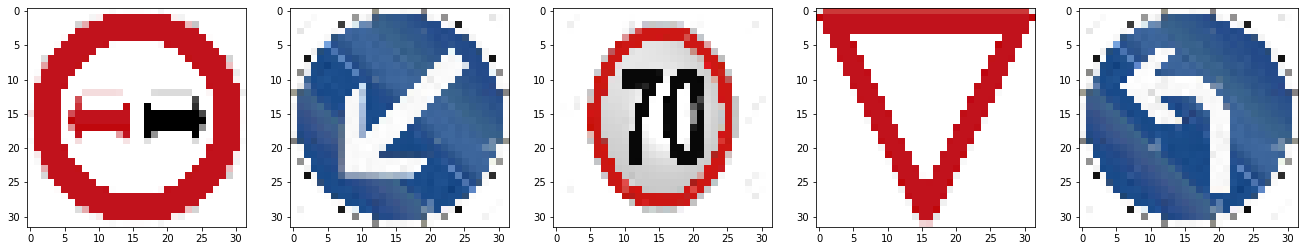

In [56]:
import matplotlib.image as mpimg

sign_1 = './new_images/nopassing.png' # label : 9 
sign_2 = './new_images/keepleft.jpg' # label : 39
sign_3 = './new_images/70.jpg' # label : 4
sign_4 = './new_images/yield.png' # label : 13
sign_5 = './new_images/turnleft.jpg' # label : 33

new_signs = [sign_1, sign_2, sign_3, sign_4, sign_5]
sign_images = []
new_images_label = [9, 39, 4, 13, 34]
dst_size = (32,32)

for sign in new_signs:
    image = cv2.imread(sign)
    image = cv2.resize(image, dst_size)
    sign_images.append(image)

fig = plt.figure(figsize=(150, 200))
ax = []

print('Original images')
for i in range(len(sign_images)):
    ax.append(fig.add_subplot(32, 32, i+1))
    plt.imshow(cv2.cvtColor(sign_images[i], cv2.COLOR_BGR2RGB))

images_grayscale = dataset_grayscale(sign_images)



In [57]:
# Check bluk accuracy of new traffic signs
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model/.'))
    test_accuracy = evaluate(images_grayscale, new_images_label)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

print('\n\nIndividual signs detection:\n\n')

# Check individual accuracy of new traffic signs

predicted_images = []
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model/.'))
    for image in images_grayscale:
        predicted_image, predicted_label, logits_result = predict_single_label(image)
        print("Sign: " + predicted_image + ", label : " + str(predicted_label))
        predicted_images.append(predicted_image)

INFO:tensorflow:Restoring parameters from ./model/./lenet
Test Accuracy = 1.000


Individual signs detection:


INFO:tensorflow:Restoring parameters from ./model/./lenet
Sign: No passing, label : 9
Sign: Keep left, label : 39
Sign: Speed limit (70km/h), label : 4
Sign: Yield, label : 13
Sign: Turn left ahead, label : 34


In [58]:
top_k = tf.nn.top_k(logits, k=5)

def top_five_outputs(x_image):
    sess = tf.get_default_session()
    top_k_output = sess.run(top_k,
                             feed_dict={
                                 x: np.expand_dims(x_image, axis=0),
                                 keep_prob_conv: 1.0,
                                 keep_prob: 1.0})
    return top_k_output

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model/.'))
    for i in range(len(images_grayscale)):
        top_five = top_five_outputs(images_grayscale[i])
        print('\nFor predicted image : ' + predicted_images[i] + ' the models top five probabilities are: ')
        for j in range(5):
            label = top_five[1][0][j]
            probability = str(top_five[0][0][j])
            print("Label: " + image_labels[label] + " \nProbability of: " + probability + "%\n")

INFO:tensorflow:Restoring parameters from ./model/./lenet

For predicted image : No passing the models top five probabilities are: 
Label: No passing 
Probability of: 64.2387%

Label: No passing for vehicles over 3.5 metric tons 
Probability of: 23.424202%

Label: Slippery road 
Probability of: 18.95478%

Label: No vehicles 
Probability of: 14.085436%

Label: Keep right 
Probability of: 13.007518%


For predicted image : Keep left the models top five probabilities are: 
Label: Keep left 
Probability of: 44.58224%

Label: Speed limit (30km/h) 
Probability of: 21.253754%

Label: Wild animals crossing 
Probability of: 13.622006%

Label: Go straight or left 
Probability of: 12.7415695%

Label: Children crossing 
Probability of: 10.602471%


For predicted image : Speed limit (70km/h) the models top five probabilities are: 
Label: Speed limit (70km/h) 
Probability of: 10.596546%

Label: Road work 
Probability of: 6.823794%

Label: Go straight or right 
Probability of: 5.826931%

Label: Stop 